In [14]:
# This notebook looks into how existing vanilla transformers do math

In [15]:
if False:
    # ----- dependencies
    !pip install transformers 
    #!pip install git+https://github.com/huggingface/transformers #accelerate deepspeed
    !pip install -U huggingface_hub
    !pip install -U accelerate
    !pip install --upgrade pip
    !pip install torch
    !pip install tokenizers==0.13.0 # may need 14 or 13 depending on python version. 13 works with python 3.8

In [16]:
# ----- dependencies
import os
import torch
from transformers import LlamaModel, LlamaConfig, LlamaForCausalLM
from huggingface_hub import login
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
# --- character-level tokenizer
class Char_Tokenizer():

    def __init__(self):
        self.chars = ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9','+','=',' ','r','c',',','|']
        self.bos_token=1
        self.eos_token=2
        self.pad_token=0
        self.vocab_size = len(self.chars)
        self.char2idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx2char = {i: ch for i, ch in enumerate(self.chars)}

    def tokenize(self, text, max_length=None):
        list = [self.char2idx[ch] for ch in text]
        list.insert(0,self.bos_token) # prefix <s>
        list.append(self.eos_token) # suffix </s>
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [self.pad_token for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])
    
tokenizer = Char_Tokenizer()
vocab_size = tokenizer.vocab_size


In [18]:

# ----- HYPERPARAMETERS
LLM_context_length = 85 # for simplicity we only do 1 question at a time
LLM_hid =      256 # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to small tansformers
LLM_layers =  2
LLM_n_heads =  4

# --- training
batch_size = 256
iterations = 10000
epochs = 1

In [19]:
# ------- Initialize model


# --- Create non-causal concept encoder (C) (tokens to concepts)
# the final autorecressive decoder-only model will use itself as the encoder - note that for char-level or removing tokenizer dependency we will need a separate encoder so that decoder take in only high level concepts
half_config = LlamaConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=LLM_hid,
    intermediate_size=LLM_hid*4,
    num_hidden_layers=LLM_layers,
    num_attention_heads=LLM_n_heads,
    num_key_value_heads=None,
    hidden_act='silu',
    max_position_embeddings=LLM_context_length*10,
    initializer_range=0.02,
    rms_norm_eps=1e-06,
    use_cache=True,
    pad_token_id=None,
    bos_token_id=tokenizer.bos_token,
    eos_token_id=tokenizer.eos_token,
    pretraining_tp=1,
    tie_word_embeddings=False,
    rope_theta=10000.0,
    rope_scaling=None)

# --- Create causal concept decoder (D) (concepts to concepts)
LLM_decoder = LlamaForCausalLM(half_config).to(device)#.to(torch.bfloat16)
LLM_decoder.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(20, 256)
    (layers): ModuleList(
      (0-1): 2 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=256, out_features=256, bias=False)
          (k_proj): Linear(in_features=256, out_features=256, bias=False)
          (v_proj): Linear(in_features=256, out_features=256, bias=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=256, out_features=1024, bias=False)
          (up_proj): Linear(in_features=256, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=256, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_fea

In [20]:
import random

eval_pairs = []

d_min=0
d_max=999

for i in range((2000//batch_size)*batch_size):
    eval_pairs.append((random.randint(d_min,d_max), random.randint(d_min,d_max)))

len(eval_pairs)

1792

In [42]:
def get_add_batch(d_min_=d_min, d_max_=d_max, val_batch_idx=-1, batch_size_=batch_size, max_length=None): # the difference between generative train and eval is that generated train can be done randomly in any order, so batches can be made independently, but eval goes through 1 epoch, so each batch need to be done in order. val_batch_idx track the batch we are doing now

    if max_length is None:
        max_length=LLM_context_length+len(str(d_max_))*2


    # get batch x, y
    batch_input_ids = torch.zeros([batch_size_,max_length],dtype=torch.long)
    for b_idx in range(batch_size_):
        
        if val_batch_idx==-1:
            num1,num2=eval_pairs[0]
            while ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):            
                num1 = random.randint(d_min_, d_max_)
                num2 = random.randint(d_min_, d_max_)
        else:
            num1,num2 = eval_pairs[val_batch_idx + b_idx]

        problem = f"{num1}+{num2}|"
        bignum = max(num1,num2)
        smallnum = min(num1,num2)
        c=0
        for d in range(1, max(len(str(num1)),len(str(num2)))+1):

            # get next digits up
            d1 = str(bignum)[-d]
            if d<=len(str(smallnum)):
                d2 = str(smallnum)[-d]
            else:
                d2 = 0
            
            # get addition result and carry
            ans = int(d1)+int(d2)+c
            if ans>9:
                ans=int(str(ans)[1])
                c=1
            else:
                c=0

            # add result, carry to CoT
            problem += f'{d1},{d2}r{ans}c{c}|'
        problem += '=' + str(num1+num2)
        


        tokenized = tokenizer.tokenize(problem, max_length=max_length)
        batch_input_ids[b_idx][:] = torch.tensor(tokenized)
    labels = batch_input_ids.clone()
    labels[labels==tokenizer.pad_token] = -100

    return batch_input_ids, labels


In [22]:
get_add_batch(batch_size_=1)

(tensor([[ 1, 11,  5,  8, 13,  7, 11, 10, 19,  8, 18, 10, 16,  5, 17,  4, 19,  5,
          18, 11, 16,  4, 17,  4, 19, 11, 18,  7, 16,  6, 17,  4, 19, 14,  4,  6,
           4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0]]),
 tensor([[   1,   11,    5,    8,   13,    7,   11,   10,   19,    8,   18,   10,
            16,    5,   17,    4,   19,    5,   18,   11,   16,    4,   17,    4,
            19,   11,   18,    7,   16,    6,   17,    4,   19,   14,    4,    6,
             4,    5,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,

In [23]:
#LLM_decoder = torch.load('transfo_add')
#1/0

In [24]:
# ------- TRAINING RUN
from transformers import top_k_top_p_filtering
import random


# --- Define the optimizer and loss function
optimizer = optim.AdamW(LLM_decoder.parameters(), lr=1e-4, betas=(0.9,0.99), weight_decay=0.1) # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to small transformers
warmup_iters = 100
lr_decay_iters = iterations
learning_rate = 1e-3
min_lr = 5e-5
import math
def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)



losses = []
accs = []
eval_losses = []
eval_accs = []
generations = []

LLM_decoder.train()
it = 0
for _ in range(epochs):
    for b in range(iterations):

        batch_input_ids, labels = get_add_batch()

        # update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = get_lr(it) #learning_rate #
            lr = param_group['lr']

        # forward pass
        # force interpretability via attention sparsity ?
        output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
        loss = output.loss
    

        # Iterate through each sample in the batch
        b_accs=[]
        for s in range(batch_size):
            # Find the index of the token with value 14 in the 'labels' tensor for the current sample
            index_14 = (labels[s] == 14).nonzero(as_tuple=True)
            index_14 = index_14[0][0]
            # Calculate accuracy only for tokens after index_14 for the current sample
            predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
            correct_predictions = (predicted_labels[index_14+1:] == labels[s, index_14+1:].roll(-1, dims=0)).float()
            # Calculate the accuracy for tokens after index_14 for the current sample
            b_accs.append(correct_predictions.mean().item())
        accs.append(torch.tensor(b_accs).mean().item())

        # Step 5: Train D on the modified inputs and token labels
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())

        it += 1

        # GET GENERATION SAMPLES (not optimized w/ cache):
        if it%100==0:
            with torch.no_grad():
                LLM_decoder.eval()



                # =============== EVAL LOSS
                total_batch_acc = []
                total_batch_loss = []
                for eval_batch in range(0, len(eval_pairs), batch_size):

                    # get eval batch
                    batch_input_ids, labels = get_add_batch(val_batch_idx=eval_batch)

                    # forward pass
                    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
                    loss = output.loss
                    total_batch_loss.append(loss.item())

                    # GET ACC
                    b_accs=[]
                    for s in range(batch_size):
                        # Find the index of the token with value 14 in the 'labels' tensor for the current sample
                        index_14 = (labels[s] == 14).nonzero(as_tuple=True)
                        index_14 = index_14[0][0]
                        eos = (labels[s] == tokenizer.eos_token).nonzero(as_tuple=True)
                        eos = eos[0][0]
                        # Calculate accuracy only for tokens after index_14 for the current sample
                        predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
                        predicted_number = predicted_labels[index_14:eos-1]
                        correct_number = labels[s,index_14+1:eos]
                        predicted_number = tokenizer.detokenize(predicted_number.tolist())
                        correct_number = tokenizer.detokenize(correct_number.tolist()) 
                        #print('Y_:'+predicted_number)
                        #print('Y:'+correct_number)
                        #print()
                        
                        # whole number acc
                        if True:
                            try:
                                b_accs.append(float(int(predicted_number)==int(correct_number)))
                            except:
                                b_accs.append(0)
                        # per digit acc
                        else:
                            correct_predictions = (predicted_labels[index_14:eos-1] == labels[s, index_14+1:eos]).float()
                            b_accs.append(correct_predictions.mean().item())
                    total_batch_acc.append(torch.tensor(b_accs).mean().item())

                eval_losses.append(torch.tensor(total_batch_loss).mean().item())
                eval_accs.append(torch.tensor(total_batch_acc).mean().item())


                # ============================================================================ GENERATIVE AUTOREGRESSIVE INFERENCE
                input_ids = torch.tensor([[tokenizer.bos_token]])
                while input_ids.shape[1] < LLM_context_length:
                    output = LLM_decoder(input_ids=input_ids.to(device))
                    logits = output.logits.cpu()
                    next_token_logits = logits[:, -1, :]
                    next_token_id = torch.multinomial(torch.softmax(next_token_logits, dim=-1), 1)
                    input_ids = torch.cat([input_ids, next_token_id], dim=1)
                print(tokenizer.detokenize(input_ids[0].tolist()))
                LLM_decoder.train()

                print(it,':', eval_losses[-1], eval_accs[-1], 'lr',lr)


<s>05+175|5,0r5c0|7,0r5c0|1,0r9c0|=955</s></s></s></s></s></s></s></s></s></s></s>r1|=180</s></s></s></s></s><pad>0r5</s>0|=500</s></s>4</s>809</s>3</s></s></s></s>30
100 : 0.6278882026672363 0.9430803656578064 lr 0.00099
<s>396+936|6,6r2c1|3,9r3c1|9,3r3c1|=1332</s></s></s></s></s>33</s>3</s>3|3,33</s></s></s>=1232</s></s></s></s>3333</s>3</s>30|=33</s>3</s>3</s>3
200 : 0.3863637447357178 1.0 lr 0.0009997656161737224
<s>210+477|7,0r7c0|7,2r9c0|4,2r6c0|=697</s></s></s></s></s></s>99</s></s></s></s></s></s>6c0|1,0r8c0|=8</s></s></s></s></s></s></s></s></s></s></s></s></s>9</s></s></s>|</s>0
300 : 0.38925406336784363 0.9927455186843872 lr 0.0009990532075323595
<s>923+599|3,9r2c1|2,9r2c1|9,5r5c1|=1522</s></s></s></s></s></s>2c0|4,9r3c1|2,5r8c0|=832</s>2</s></s></s></s></s></s>3</s></s></s></s></s></s></s></s>
400 : 0.37905287742614746 1.0 lr 0.000997863467494781
<s>986+157|6,7r3c1|8,5r4c1|9,1r1c1|=1143</s></s></s></s> 44</s></s></s></s></s></s>13c0|4,3r8c0|5,4r1|3r4c0|=44</s></s></s></s>8,

KeyboardInterrupt: 

In [2]:
import os
os.getcwd()

'/home/idmi'

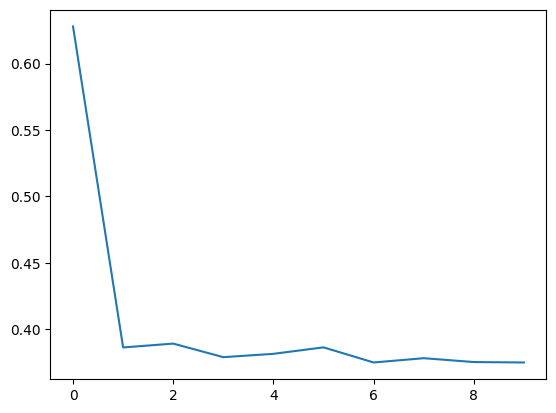

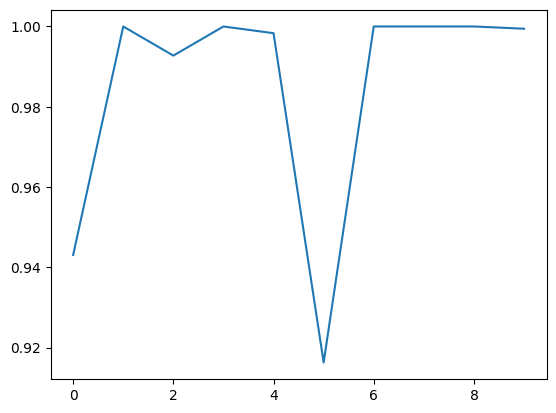

In [37]:
import matplotlib.pyplot as plt
plt.plot(eval_losses)
plt.show()
plt.plot(eval_accs)
plt.show()
torch.save(LLM_decoder, f'transfo_add_{LLM_layers}_{LLM_hid}_cot1')

In [53]:
#get OOD performance
dmax=0
i=0
ood_losses=[]
ood_accs=[]
while i<20:
    dmax+=9*10**i
    i+=1


    # =============== EVAL LOSS
    total_batch_acc = []
    total_batch_loss = []
    for eval_batch in range(0, len(eval_pairs), batch_size):

        # get eval batch
        batch_input_ids, labels = get_add_batch(d_min_=0, d_max_=dmax, val_batch_idx=eval_batch if dmax<d_max else -1, max_length=300)

        # forward pass
        with torch.no_grad():
            output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token

        # GET ACC
        b_accs=[]
        b_losss=[]
        for s in range(batch_size):
            # Find the index of the token with value 14 (=) in the 'labels' tensor for the current sample
            index_14 = (labels[s] == 14).nonzero(as_tuple=True)
            index_14 = index_14[0][0]
            eos = (labels[s] == tokenizer.eos_token).nonzero(as_tuple=True)
            try:
                eos = eos[0][0]
            except IndexError:
                eos = labels[s].shape[0]-1 # if no eos token, get last token
            # Calculate accuracy only for tokens after index_14 for the current sample
            predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
            predicted_number = predicted_labels[index_14:eos-1]
            correct_number = labels[s,index_14+1:eos]
            predicted_number = tokenizer.detokenize(predicted_number.tolist())
            correct_number = tokenizer.detokenize(correct_number.tolist()) 
            
            b_losss.append(torch.nn.CrossEntropyLoss().to(device)(output.logits[s,index_14:eos-1].view(-1,tokenizer.vocab_size).to(device), labels[s,index_14+1:eos].view(-1).to(device)).item())

            # whole number acc
            if True:
                try:
                    b_accs.append(float(int(predicted_number)==int(correct_number)))
                except:
                    b_accs.append(0)
            # per digit acc
            else:
                correct_predictions = (predicted_labels[index_14:eos-1] == labels[s, index_14+1:eos]).float()
                b_accs.append(correct_predictions.mean().item())
                
        total_batch_acc.append(torch.tensor(b_accs, dtype=torch.float).mean().item())
        total_batch_loss.append(torch.tensor(b_losss, dtype=torch.float).mean().item())

    ood_losses.append(torch.tensor(total_batch_loss).mean().item())
    ood_accs.append(torch.tensor(total_batch_acc).mean().item())

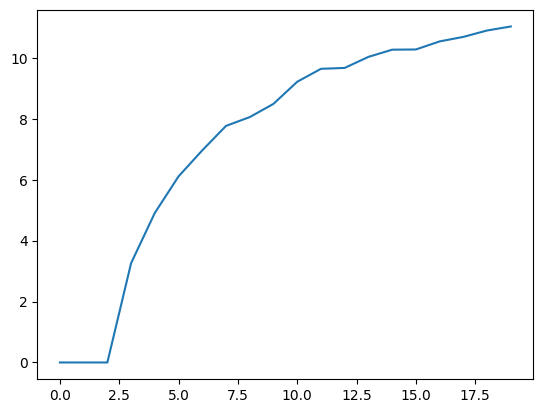

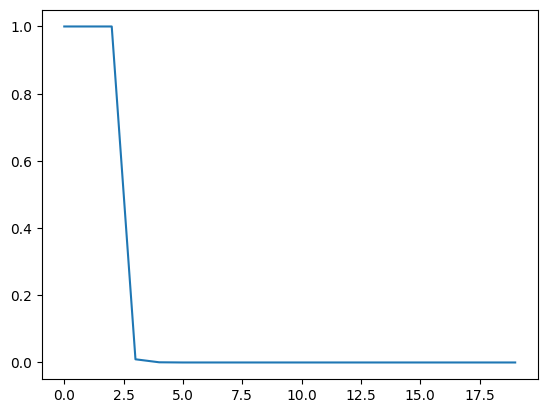

[1.0,
 1.0,
 1.0,
 0.009486607275903225,
 0.0005580357392318547,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [55]:
plt.plot(ood_losses)
plt.show()
plt.plot(ood_accs)
plt.show()
ood_accs

In [ ]:
import sys
!{sys.executable} -m pip install bertviz


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /media/idmi/Z/Ubuntu_folder/miniconda3/envs/minerl/bin/python -m pip install --upgrade pip


In [ ]:
from bertviz import model_view

# create math input
batch_input_ids, labels = get_add_batch(batch_size_=1)



# forward pass
LLM_decoder.eval()
with torch.no_grad():
    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_attentions=True) 
attention = output[-1]

cut_attention = ()
for i in range(len(attention)):
    print(attention[i].shape)
    cut_attention += (attention[i][:,:,:45,:45],)

a=tokenizer.detokenize(batch_input_ids[0,:45].tolist())
print(a)
model_view(cut_attention, a.replace('<s>', '_').replace('</s>', '_').replace('<pad>', '_'))


torch.Size([1, 4, 91, 91])
torch.Size([1, 4, 91, 91])
<s>880+508|0,8r8c0|8,0r8c0|8,5r3c1|=1388</s><pad><pad><pad><pad><pad><pad>


<IPython.core.display.Javascript object>

In [ ]:
1/0


# plot linear probe success at finding number

# in order to interpret how the network calculates, we attempt to identify wher different parts of the answer are calculated, specifically looking at all transfo block outputs at every layer at every timestep 

# we decide to look for where the following calculations are completed:
# - we will be unlikely to identify a location where the final answer is stored, because the answer is likely distributed among the tokens - the network is unlikely to store the entire answer in a single hidden activation.
# We search for this anyway, training a linear probe with a neurons for each possible digit for each  digit position (since we max out at 1998 here, we train with 4 digits * 10)
# it is likely that even if the entire answer is not stored in a hidden activation, we can recover the value of a single digit at a single location

# we only train the probe on sequences the network is correct on

In [ ]:
import torch
device='cuda'
torch.nn.Sequential(
        torch.nn.Linear(in_features=256, out_features=4*10),
        torch.nn.Sigmoid()
    ).to(device)

Sequential(
  (0): Linear(in_features=256, out_features=40, bias=True)
  (1): Sigmoid()
)

In [ ]:

# ------- TRAINING RUN
import random


# -- linear probe. Train one per layer, each probe is train on all token positions in its respective layer
linear_probes=[]
optimizers = []
cuda_streams = [] # we want to train different matrices in parallel
for l in range(LLM_layers):
    linear_probes.append(
        torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=4*10),
        ).to(device)
    )
    optimizers.append(optim.Adam(linear_probes[l].parameters(), lr=1e-5)) # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to small transformers
    cuda_streams.append(torch.cuda.Stream())

# learning rate. why would I use a complicated learning rate like this on a linear probe? just for fun.
import math
learning_rate=1e-4
lr_decay_iters=10000
warmup_iters=100
min_lr = 1e-5
def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)


criterion = torch.nn.CrossEntropyLoss()

probe_losses = []
probe_accs = []

LLM_decoder.eval()
it = 0
for _ in range(epochs):
    for b in range(iterations):

        # get batch x, y
        batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
        results=[]
        for b_idx in range(batch_size):
            num1,num2=eval_pairs[0]
            while ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):            
                num1 = random.randint(0, 999)
                num2 = random.randint(0, 999)
            result = str(num1 + num2)
            results.append(result)
            problem = f"{num1}+{num2}={result}"
            tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
            batch_input_ids[b_idx][:] = torch.tensor(tokenized)
        labels = batch_input_ids.clone()
        labels[labels==tokenizer.pad_token] = -100


        # forward pass
        # force interpretability via attention sparsity?
        with torch.no_grad():
            output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_hidden_states=True) # just start with first token

        # update learning rate
        for o in range(LLM_layers):
            for param_group in optimizers[o].param_groups:
                param_group['lr'] = get_lr(it)

        xs = []
        ys = []
        formatted_results = ["{:04d}".format(int(ans)) for ans in results]
        for l in range(LLM_layers):
            x = output.hidden_states[l] # get activations at layer l - should have shape [B, T, E]
            y = torch.full([x.shape[0], x.shape[1], 4, 10], 0.01, device=device) # given a hidden state, linear probe tries to guess the value of each digit at each position

            #x = x[:,6:12]
            #y = y[:,6:12]

            # linear probe is trained to estimate the full final answer at every timestep.
            for b, ans in enumerate(formatted_results):
                for d in range(4):
                    digit_ans = int(formatted_results[b][d])
                    y[b,:,d,digit_ans] = 0.99
            
            x = x.reshape([x.shape[0]*x.shape[1],LLM_hid])
            y = y.reshape([y.shape[0]*y.shape[1], 4, 10])

            xs.append(x) # write x,y to arrays so we don't mutate them during parallel training
            ys.append(y)

            with torch.cuda.stream(cuda_streams[l]):
                y_ = linear_probes[l](xs[l])
                y_ = y_.reshape([y_.shape[0], 4, 10]) # reshape from [B,40] to [B,4,10]

                loss=0
                for d in range(4):
                    loss += criterion(y_[:,d,:], ys[l][:,d,:])
                loss/=4
                probe_losses.append(loss.item())

                loss.backward()
                optimizers[l].step()
                optimizers[l].zero_grad(set_to_none=True)
                loss=0

                y = y.reshape(batch_size, LLM_context_length, 4, 10)
                y_ = y_.reshape(batch_size, LLM_context_length, 4, 10)

                acc = (y.argmax(dim=-1)==y_.argmax(dim=-1)).half().mean().item()
                probe_accs.append(acc)
                
        torch.cuda.synchronize()
        del xs, ys, 
        it += 1

        if it%100==0:
            print(it, probe_losses[-1], probe_accs[-1])









        if False:
            with torch.no_grad():

                # =============== EVAL LOSS
                total_batch_acc = []
                for eval_batch in range(0, len(eval_pairs), batch_size):
                    batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
                    for b_idx in range(batch_size):
                        num1,num2 = eval_pairs[eval_batch + b_idx]
                        result = str(num1 + num2)
                        problem = f"{num1}+{num2}={result}"
                        tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
                        batch_input_ids[b_idx][:] = torch.tensor(tokenized)
                    labels = batch_input_ids.clone()
                    labels[labels==tokenizer.pad_token] = -100

                    # forward pass
                    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
                    loss = output.loss
                    eval_losses.append(loss.item())

                    # GET ACC
                    b_accs=[]
                    for s in range(batch_size):
                        # Find the index of the token with value 14 in the 'labels' tensor for the current sample
                        index_14 = (labels[s] == 14).nonzero(as_tuple=True)
                        index_14 = index_14[0][0]
                        eos = (labels[s] == tokenizer.eos_token).nonzero(as_tuple=True)
                        eos = eos[0][0]
                        # Calculate accuracy only for tokens after index_14 for the current sample
                        predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
                        predicted_number = predicted_labels[index_14:eos-1]
                        correct_number = labels[s,index_14+1:eos]
                        predicted_number = tokenizer.detokenize(predicted_number.tolist())
                        correct_number = tokenizer.detokenize(correct_number.tolist()) 
                        #print('Y_:'+predicted_number)
                        #print('Y:'+correct_number)
                        #print()
                        
                        # whole number acc
                        if True:
                            try:
                                b_accs.append(float(int(predicted_number)==int(correct_number)))
                            except:
                                b_accs.append(0)
                        # per digit acc
                        else:
                            correct_predictions = (predicted_labels[index_14:eos-1] == labels[s, index_14+1:eos]).float()
                            b_accs.append(correct_predictions.mean().item())
                    total_batch_acc.append(torch.tensor(b_accs).mean().item())
                eval_accs.append(torch.tensor(total_batch_acc).mean().item())

                print(it,':', eval_losses[-1], eval_accs[-1], 'lr',get_lr(it))


100 2.4891881942749023 0.1595458984375
200 2.240224599838257 0.2327880859375
300 2.1706600189208984 0.25390625
400 2.132843494415283 0.2802734375
500 2.112732172012329 0.291259765625
600 2.1111249923706055 0.291748046875
700 2.09975528717041 0.2890625
800 2.108776330947876 0.287353515625
900 2.0982789993286133 0.293212890625
1000 2.0966973304748535 0.290283203125
1100 2.0919768810272217 0.294189453125
1200 2.102783203125 0.288818359375
1300 2.0831868648529053 0.305419921875
1400 2.088513135910034 0.29150390625
1500 2.0833802223205566 0.294677734375
1600 2.065988063812256 0.313720703125
1700 2.0848817825317383 0.29833984375
1800 2.0730743408203125 0.307373046875
1900 2.0812175273895264 0.310302734375
2000 2.070246458053589 0.306396484375
2100 2.083569049835205 0.30078125
2200 2.0748322010040283 0.308837890625
2300 2.0727570056915283 0.297607421875
2400 2.070702075958252 0.310791015625
2500 2.066385269165039 0.30615234375
2600 2.0602757930755615 0.320068359375
2700 2.0721781253814697 0.3

KeyboardInterrupt: 

In [ ]:
1/0

In [ ]:
for l in range(LLM_layers):
    torch.save(linear_probes[l], f'lprobe{l}')

: 

In [ ]:
for i in range(LLM_context_length):
    linear_probes[l] = torch.load(f'lprobe{l}')

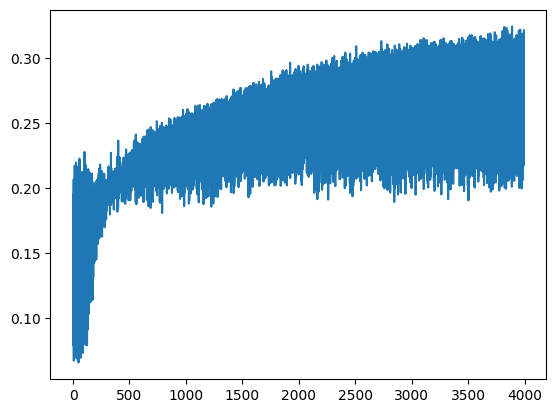

In [ ]:
import matplotlib.pyplot as plt
plt.plot(probe_accs)

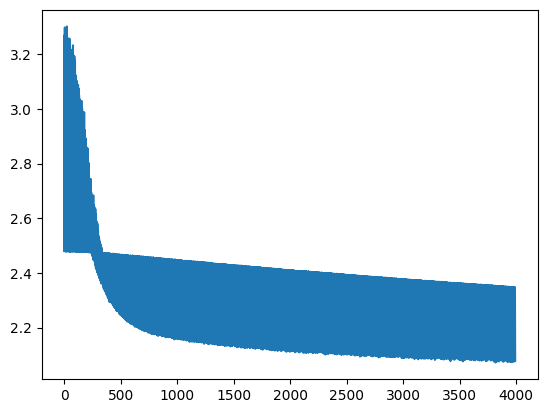

In [ ]:
plt.plot(probe_losses)

In [ ]:
# SCALE THE ACCURACIES OF PROBE PREDICTIONS

# remember that if a probe is shown abc+ijk=xyz, given just the first number, if the second digit is small (0), you have a decent change of the first number being the same as the first number in the final answer.
# if digit 1 is 0, the second numbers first digit must be 0 and the 2nd digit can be between 0 and 9 and the final answer will ahve the same number. 
# P(ANSd0=NUM1d0|NUM1d1=0) = P(NUM2d0=0)=1/10 * P(NUM2d1d2+NUM1d1d2<100)=10/10 *
# P(ANSd0=NUM1d0|NUM1d1=5) = 1/10 * 10/10 

In [ ]:
# display
def ANSI_func(brightness):
    if brightness > 0.7:
        return '\033[92m'  # Green
    elif brightness > 0.3:
        return '\033[93m'  # Yellow
    else:
        return '\033[91m'  # Red
    


# get batch x, y
batch_input_ids = torch.zeros([1,LLM_context_length],dtype=torch.long)
results=[]
num1 = 500
num2 = 500
if ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):
    print("this sample is in eval!")
result = str(num1 + num2)
results.append(result)
problem = f"{num1}+{num2}={result}"
tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
batch_input_ids[0][:] = torch.tensor(tokenized)
labels = batch_input_ids.clone()
labels[labels==tokenizer.pad_token] = -100


# forward pass
# force interpretability via attention sparsity?
with torch.no_grad():
    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_hidden_states=True) # just start with first token

xs = []
ys = []
formatted_results = ["{:04d}".format(int(ans)) for ans in results]
print(formatted_results)

for l in range(LLM_layers-1, -1, -1):
    print()
    x = output.hidden_states[l] # get activations at layer l - should have shape [B, T, E]
    y = torch.full([x.shape[0], x.shape[1], 4, 10], 0.01, device=device) # given a hidden state, linear probe tries to guess the value of each digit at each position

    # linear probe is trained to estimate the full final answer at every timestep.
    for b, ans in enumerate(formatted_results):
        for d in range(4):
            digit_ans = int(formatted_results[b][d])
            y[b,:,d,digit_ans] = 0.99
    
    x = x.reshape([x.shape[0]*x.shape[1],LLM_hid])
    y = y.reshape([y.shape[0]*y.shape[1], 40])

    xs.append(x) # write x,y to arrays so we don't mutate them during parallel inference
    ys.append(y)

    with torch.cuda.stream(cuda_streams[l]):
        with torch.no_grad():
            y_ = linear_probes[l](xs[(LLM_layers-1)-l]).reshape([1, LLM_context_length, 4, 10]) # reshape from [B,40] to [B,4,10]
        y_ = torch.nn.Softmax(dim=-1)(y_)
        estimated_ds = y_.argmax(dim=-1)
        certainty_ds = y_.amax(dim=-1)
    
    for t in range(LLM_context_length):
        estimated_d = ''.join([str(digit) for digit in estimated_ds[0, t].tolist()])
        for d in range(4):
            print(f"{ANSI_func(certainty_ds[0,t,d])}{estimated_d[d]}", end='')
        print('\t',end='')
    #print(y_[0,:,0,:].argmax(dim=-1))

print()
for i in range(len(problem)):
    print(problem[i]+'\t',end='')

        
torch.cuda.synchronize()
del xs, ys, 
it += 1

['1000']

1219	0543	0110	1110	1011	0999	0111	0111	1364	1211	1009	1089	1010	1110	1011	1241	1011	1011	1010	1000	1000	1080	1215	1111	1111	1111	1011	1011	1111	1111	1111	1111	1111	1111	1111	1111	1111	1111	1011	1011	
1219	0954	0000	0000	1010	1101	0879	0879	0554	1111	1080	1000	1000	0330	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	1000	
0000	0555	0000	0000	0118	0555	0000	0000	0128	0111	0000	0000	0000	0118	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	0868	
5	0	0	+	5	0	0	=	1	0	0	0	

In [ ]:
tokenizer.detokenize(output.logits[0,6:12].argmax(dim=-1).tolist()[1:])

'=1022'

In [ ]:
accuracy_when_ablated = torch.zeros([LLM_layers, LLM_context_length])

for i in range():
    